In [2]:
import math
import json
import pandas as pd
import numpy as np
from ete3 import Tree
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def get_numdate(input_file_branch_lengths, node_name):
    with open(input_file_branch_lengths, "r") as bl_handle:
        branch_lengths = json.load(bl_handle)
        for node, v in branch_lengths['nodes'].items():
            if node == node_name:
                return v['numdate']


In [43]:
def get_tmrca(input_file_branch_lengths, tree, strains):
    
    tree_strains = []
    
    for leaf in tree:
        if leaf.name in strains:
            tree_strains.append(leaf.name)
            

    common_ancestor = tree.get_common_ancestor(tree_strains)

    common_ancestor_numdate = get_numdate(input_file_branch_lengths, common_ancestor.name)
    

    times_to_common_ancestor = []

    for leaf in tree_strains:
        leaf_numdate = get_numdate(input_file_branch_lengths, leaf)
        pairwise_distance = leaf_numdate - common_ancestor_numdate
        times_to_common_ancestor.append(pairwise_distance)

    tmrca = sum(times_to_common_ancestor)/len(times_to_common_ancestor)
    
    return tmrca


In [5]:
def separate_clades(cov, gene):
    if cov == 'hku1':
        clade_file = '../'+str(cov)+'/results/clades_full.json'
    else:
        if gene =='spike' or gene == 's1' or gene == 's2':
            clade_file = '../'+str(cov)+'/results/clades_spike.json'
        else:
            clade_file = '../'+str(cov)+'/results/clades_full.json'
    
    clade_lists = []
    with open(clade_file, "r") as clade_handle:
        clades = json.load(clade_handle)
        for node, v in clades['nodes'].items():
            if 'NODE' not in node:
                clade_lists.append({'clade':v['clade_membership'],
                                   'strain':node})

    clade_df = pd.DataFrame(clade_lists)
    return clade_df

In [6]:
def tmrca_by_clade(cov, gene, window, clade, min_seqs, year_max=None, year_min=None):

    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    input_file_branch_lengths = '../'+str(cov)+'/results/branch_lengths_'+str(cov)+'_'+str(gene)+'.json'
    input_tree = Tree('../'+str(cov)+'/results/tree_'+str(cov)+'_'+str(gene)+'.nwk', format=1)
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'
    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    
    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)

    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     

    #initiate lists to record all time windows
    year_windows = []
    window_midpoint = []
    seqs_in_window = []
    tmrcas = []

    
    for years, subset_viruses in virus_time_subset.items():

        #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:
            year_windows.append(years)
            window_start = int(years[0:4])
            window_end = int(years[-4:])
            window_midpoint.append((window_start + window_end)/2)
            seqs_in_window.append(len(subset_viruses))
            tmrca = get_tmrca(input_file_branch_lengths, input_tree, subset_viruses)
            tmrcas.append(tmrca)
    

    return year_windows, window_midpoint, seqs_in_window, tmrcas

In [47]:
def plot_tmrca(cov, genes, window, clade, min_seqs, year_max=None, year_min=None):
    
    data_to_plot = []
    for gene in genes:
        (year_windows, window_midpoint,seqs_in_window, tmrcas) = tmrca_by_clade(cov, gene, window, 
                                                                        clade, min_seqs, 
                                                                        year_max, year_min)
        for year in range(len(window_midpoint)):
            data_to_plot.append({'cov_clade': str(cov)+str(clade), 'gene': gene,
                                 'year': window_midpoint[year], 
                                 'tmrca': tmrcas[year]})
        
    df_to_plot = pd.DataFrame(data_to_plot)
    
    color_map = {'oc43A': '#CB4335', 'oc43B':'#FF9A00',  '229eNone': '#2E86C1', 
                 'nl63A': '#009888', 'nl63B': '#87C735', 'hku1A': '#7c5295', 'hku1B': '#b491c8'}
    
    g = sns.FacetGrid(df_to_plot, col='gene', col_wrap=2, hue='cov_clade', height=6, aspect=1,
                      palette=color_map, sharey=True, sharex=False)
    g.map(sns.pointplot, 'year', 'tmrca', ci=None)
        
    

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


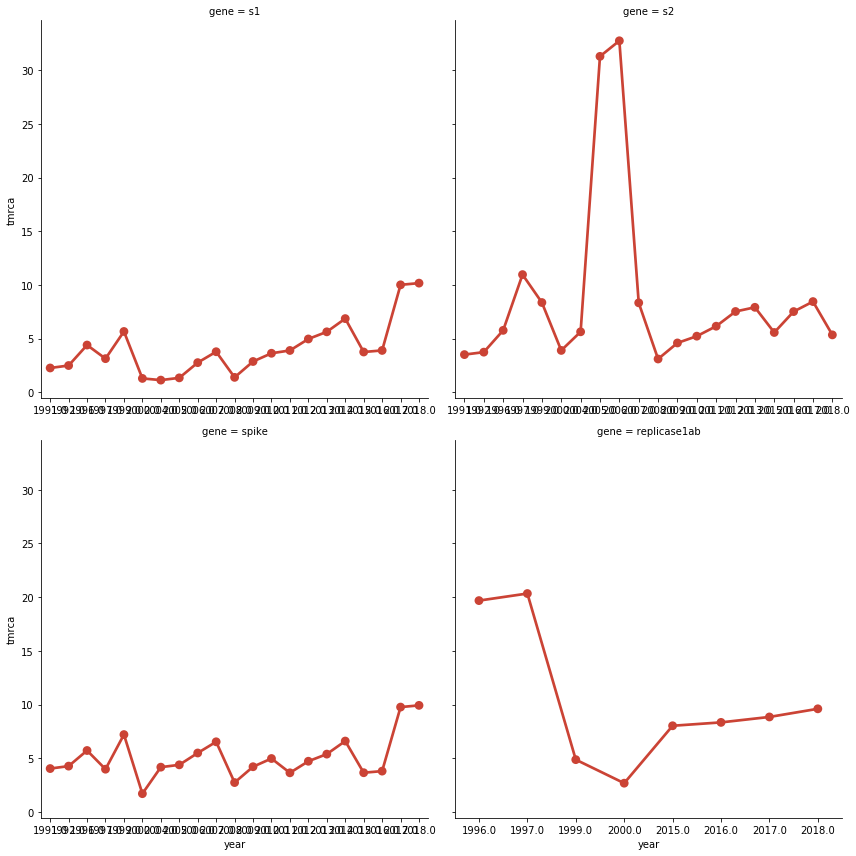

In [8]:
plot_tmrca('oc43', ['s1', 's2', 'spike', 'replicase1ab'], 2, 'A', 3, year_max=None, year_min=None)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


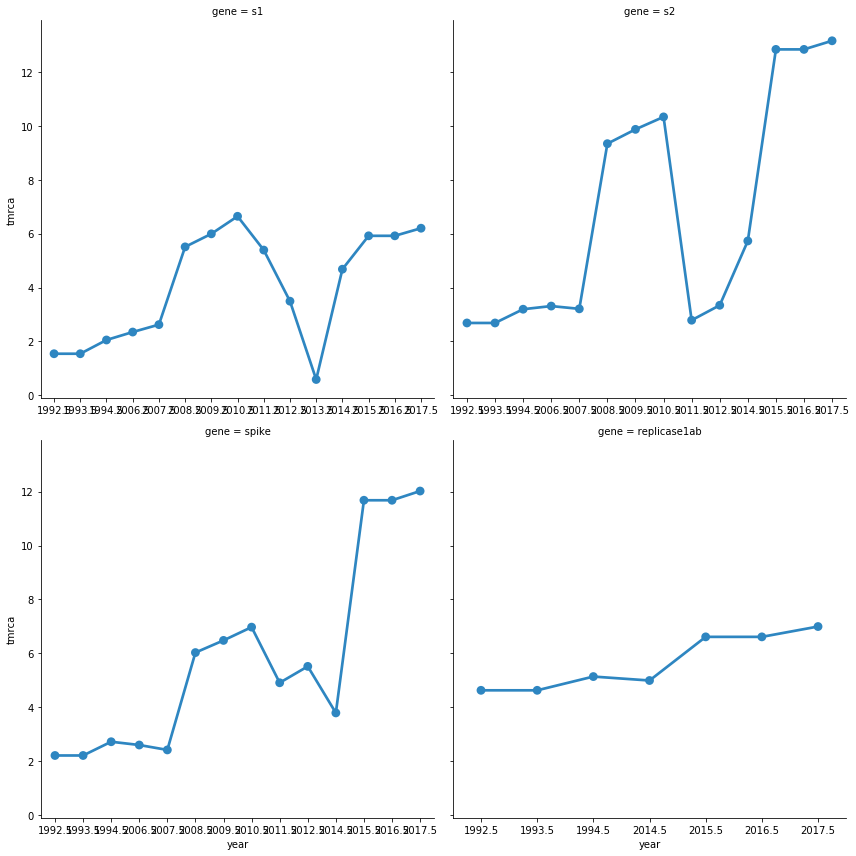

In [48]:
plot_tmrca('229e', ['s1', 's2', 'spike', 'replicase1ab'], 3, None, 3, year_max=None, year_min=None)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


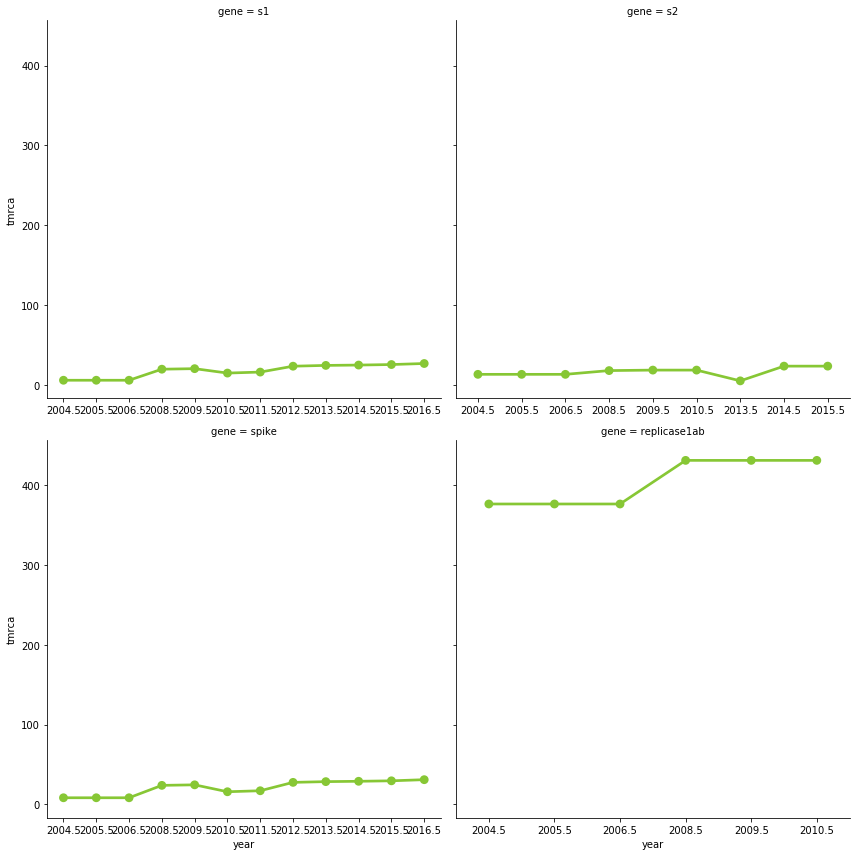

In [50]:
plot_tmrca('nl63', ['s1', 's2', 'spike', 'replicase1ab'], 3, 'B', 3, year_max=None, year_min=None)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


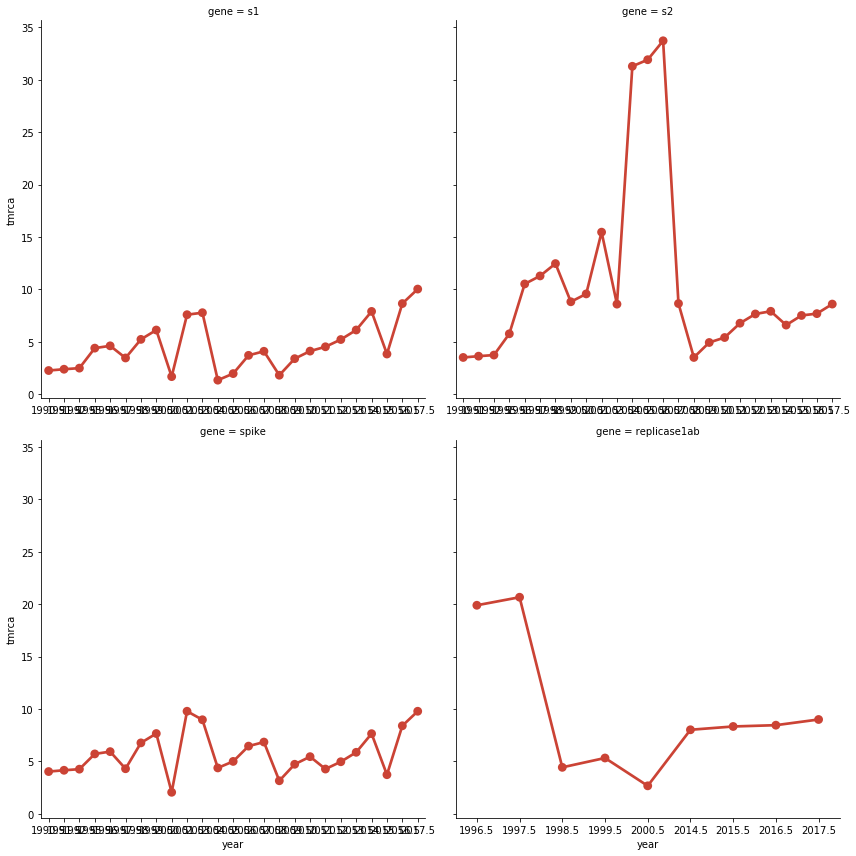

In [76]:
plot_tmrca('oc43', ['s1', 's2', 'spike', 'replicase1ab'], 3, 'A', 3, year_max=None, year_min=None)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


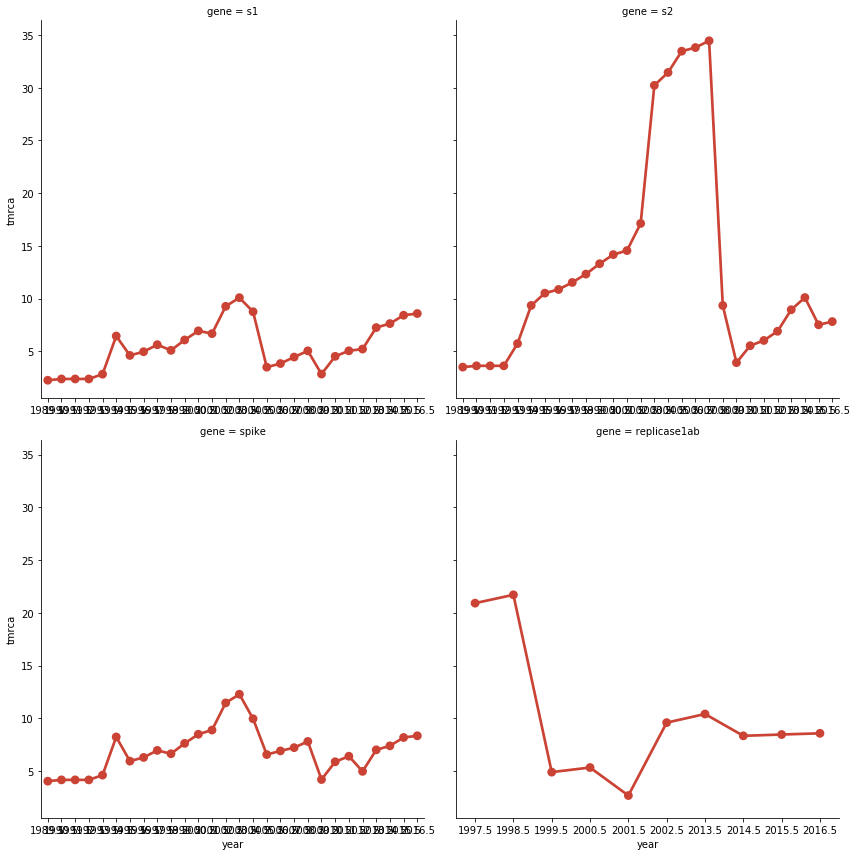

In [77]:
plot_tmrca('oc43', ['s1', 's2', 'spike', 'replicase1ab'], 5, 'A', 3, year_max=None, year_min=None)